In [ ]:
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

#**Loading Data**

In [ ]:
store = pd.read_csv("store.csv")
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
train = pd.read_csv("train.csv")
train['Date'] = pd.to_datetime(train['Date'])
train.set_index('Date', inplace=True)
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [ ]:
# Extracting data
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.isocalendar().week
# Adding new variable
train['SalesPerCustomer'] = train['Sales']/train['Customers']
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalesPerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118


In [ ]:
test = pd.read_csv("test.csv")
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


# **Exploratory Data Analysis**

In [ ]:
store.shape, train.shape, test.shape

((1115, 10), (1017209, 13), (41088, 8))

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Store             1017209 non-null  int64  
 1   DayOfWeek         1017209 non-null  int64  
 2   Sales             1017209 non-null  int64  
 3   Customers         1017209 non-null  int64  
 4   Open              1017209 non-null  int64  
 5   Promo             1017209 non-null  int64  
 6   StateHoliday      1017209 non-null  object 
 7   SchoolHoliday     1017209 non-null  int64  
 8   Year              1017209 non-null  int32  
 9   Month             1017209 non-null  int32  
 10  Day               1017209 non-null  int32  
 11  WeekOfYear        1017209 non-null  UInt32 
 12  SalesPerCustomer  844340 non-null   float64
dtypes: UInt32(1), float64(1), int32(3), int64(7), object(1)
memory usage: 94.1+ MB


In [ ]:
train['SalesPerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalesPerCustomer, dtype: float64

On an average, customers spend 9.49$ per day. But there are days with Sales per customer equal to zero.

In [ ]:
# Data when store is closed
train_storeclosed = train[(train.Open == 0)]
train_storeclosed.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalesPerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


array([[<Axes: title={'center': 'DayOfWeek'}>]], dtype=object)

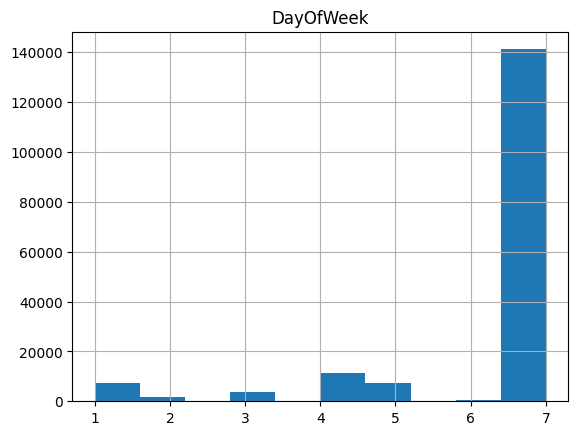

In [ ]:
train_storeclosed.hist('DayOfWeek')

From the bar chart, we can see that store is closed the most on 7th day i.e Sunday.

In [ ]:
# Checking null values in train
train.isnull().sum()

Store                    0
DayOfWeek                0
Sales                    0
Customers                0
Open                     0
Promo                    0
StateHoliday             0
SchoolHoliday            0
Year                     0
Month                    0
Day                      0
WeekOfYear               0
SalesPerCustomer    172869
dtype: int64

In [ ]:
# No null values in train except in 'Sales per customer' which is null because number of customers is zero, so replacing it with zero.
#train.fillna(0, inplace=True)

In [ ]:
# Number of days when store is closed
train_storeclosed.shape[0]

172817

Sales will be zero when when store is closed

In [ ]:
# Number of days when store is open but sales is zero
train[(train.Open == 1) & (train.Sales == 0)].shape[0]

54

In [ ]:
# Checking null values in store
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [ ]:
# Replacing null values for 'CompetitonDistance' with median
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)
# We have no information about the other columns, so replcae null values by 0
store.fillna(0, inplace=True)

In [ ]:
store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [ ]:
# Checking null values in test
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [ ]:
# We assume store is open in case of null values in test
test.fillna(1, inplace=True)

In [ ]:
test.isnull().sum().sum()

0

In [ ]:
# Joining train and store
joined = pd.merge(train, store, on='Store', how='inner')
joined.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [ ]:
joined.groupby('StoreType')[['Customers', 'Sales', 'SalesPerCustomer']].sum().sort_values('Sales', ascending=False)

,Customers,Sales,SalesPerCustomer
StoreType,,,
a,363541434,3165334859,4.043129e+06
d,156904995,1765392943,2.918350e+06
c,92129705,783221426,9.744876e+05
b,31465621,159231395,7.987612e+04


In [ ]:
# Number of days when store is closed and sales is zero
joined[(joined.Open == 0) | (joined.Sales==0)].shape[0]

172871

In [ ]:
# Number of days when store is open and sales is greater than zero
joined_storeopen = joined[~((joined.Open == 0) | (joined.Sales== 0))]
joined_storeopen.shape[0]

844338

### Correlation Analysis

<Axes: >

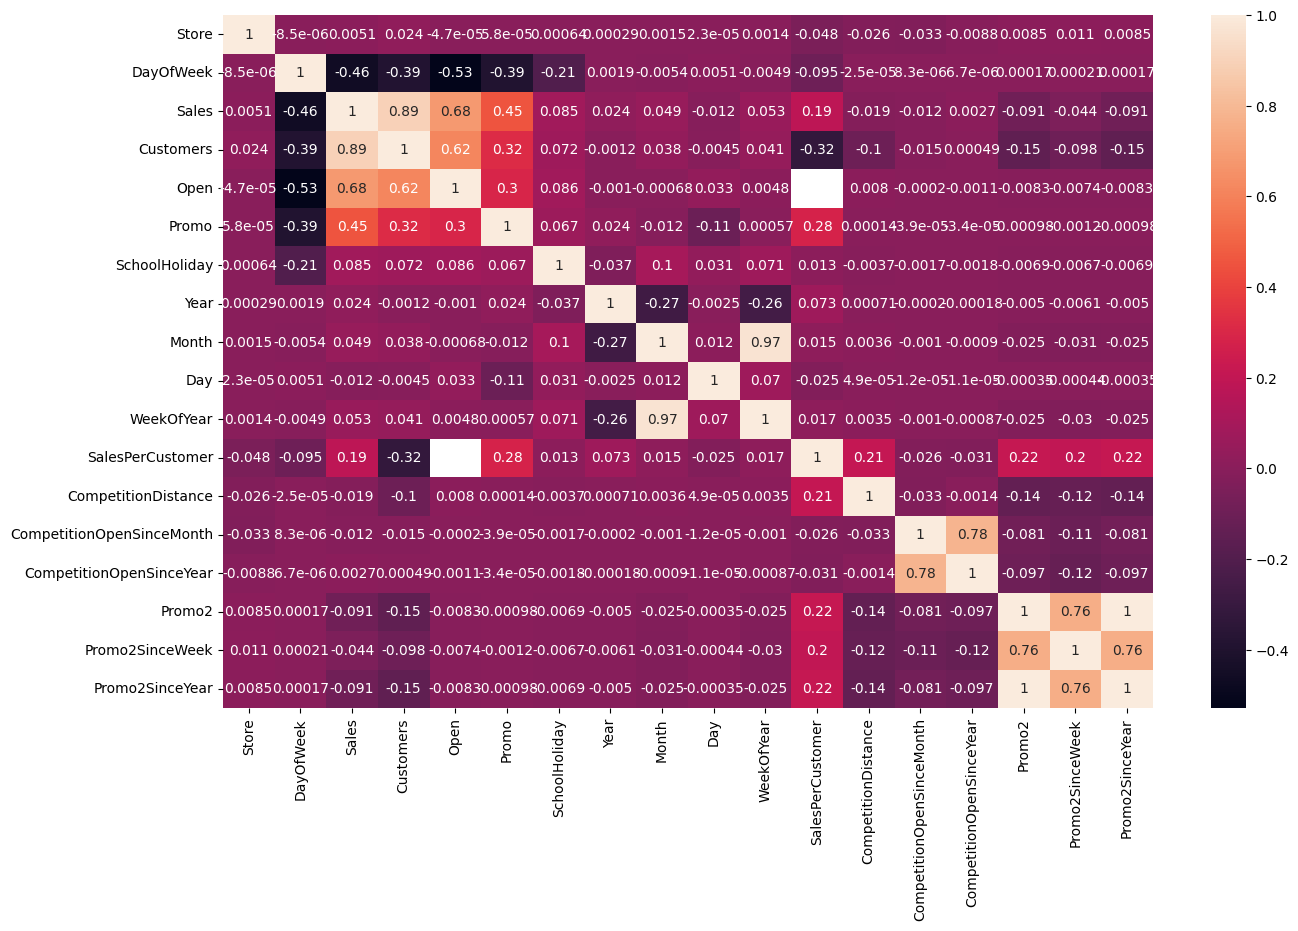

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
# Dropping non-numeric values for analysis
joined1 = joined.select_dtypes(include=['number'])
plt.figure(figsize=(15, 9))
sns.heatmap(joined1.corr(), annot=True)

We can observe a strong positive correlation between the amount of sales and number of customers. We can also observe a positive correlation between a running promotion i.e Promo = 1 and number of customers.

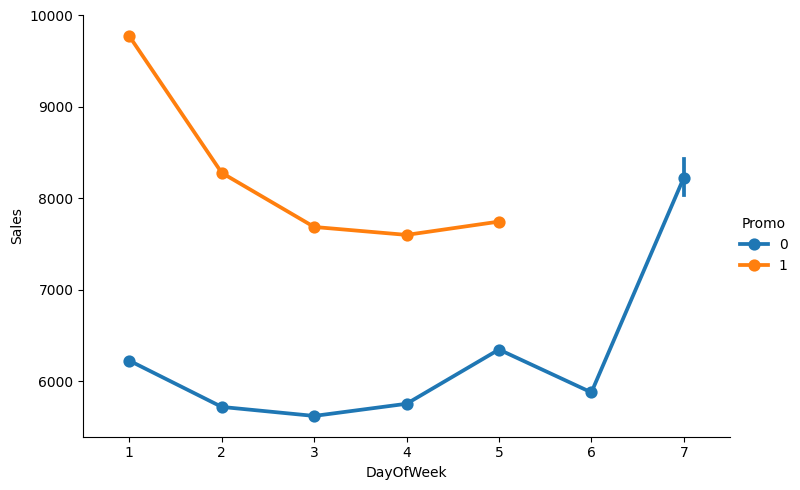

In [ ]:
# Plotting the trend of sales over days
sns.catplot(data= joined_storeopen, x='DayOfWeek', y="Sales",hue='Promo', kind='point', height=5, aspect=1.5)

We can see that promotions are not given in weekends (Saturday and Sunday) (i.e Promo = 0). As common people buy the most on weekends, without promotion sales are increased in a dramatic way. Promotions are highest on monday and as well as sales are highest on that day.

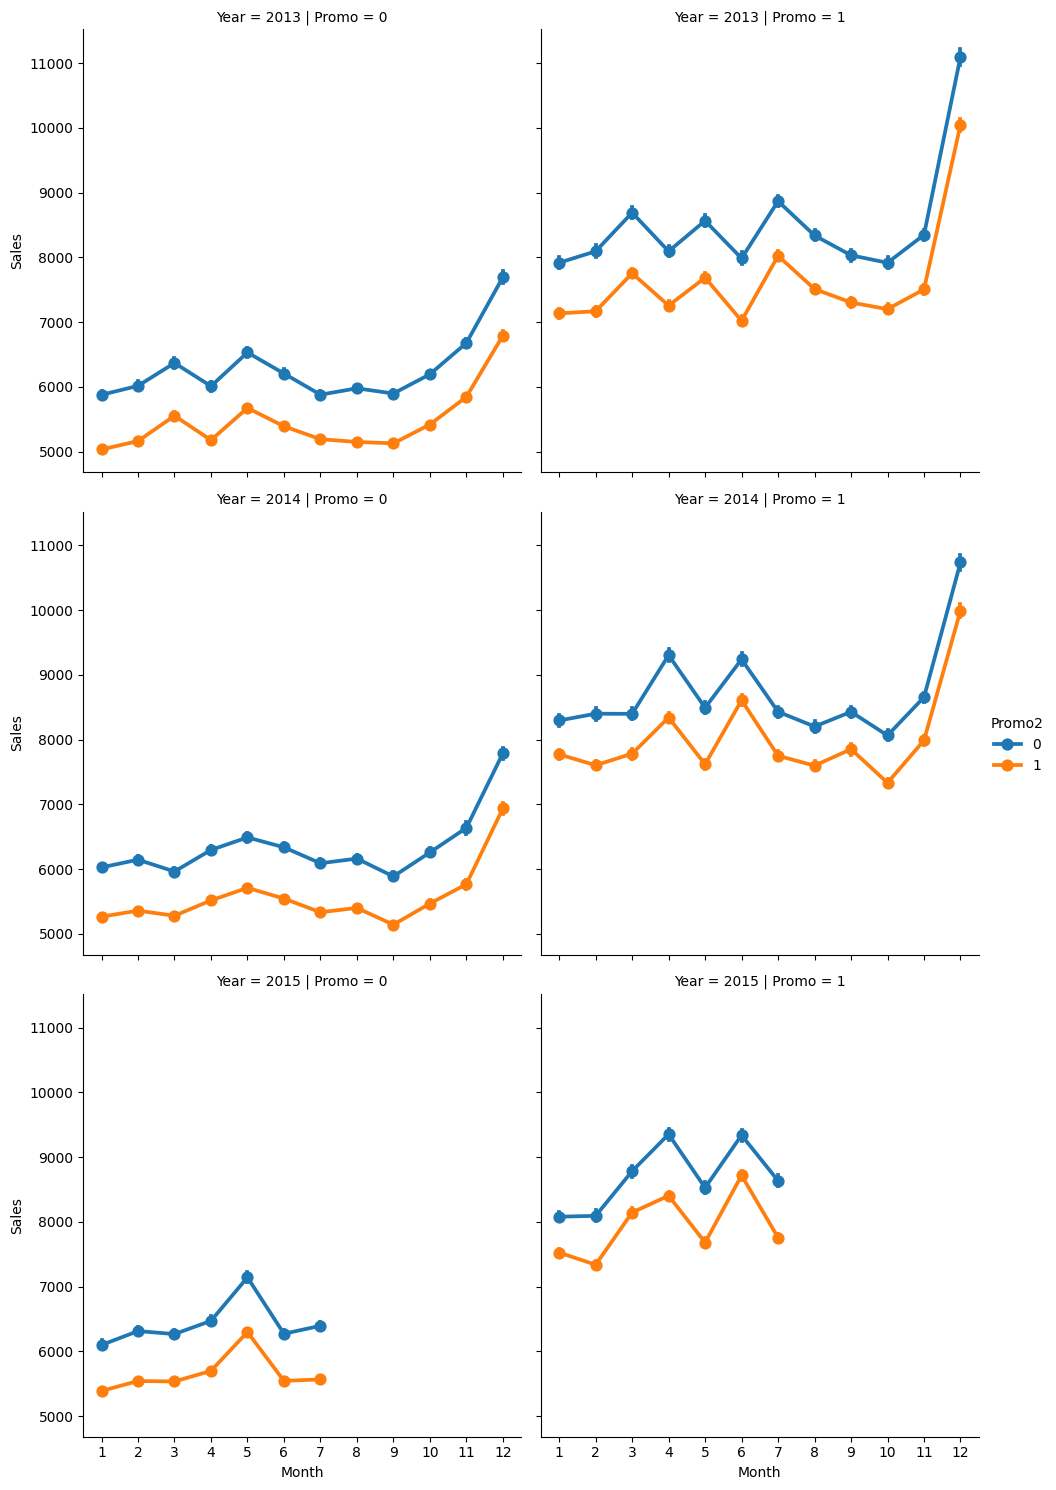

In [ ]:
# Plotting the trend of sales over months
sns.catplot(data = joined_storeopen, x='Month', y='Sales', col ='Promo', hue='Promo2', row='Year', kind='point', height=5, aspect=1)

# **Time Series Analysis**

In [ ]:
pd.plotting.register_matplotlib_converters()

In [ ]:
# Data should be float type
train['Sales'] = train['Sales'] * 1.00
train['Sales'].head()

Date
2015-07-31     5263.0
2015-07-31     6064.0
2015-07-31     8314.0
2015-07-31    13995.0
2015-07-31     4822.0
Name: Sales, dtype: float64

In [ ]:
train.Store.unique()

array([   1,    2,    3, ..., 1113, 1114, 1115])

<Axes: xlabel='Date'>

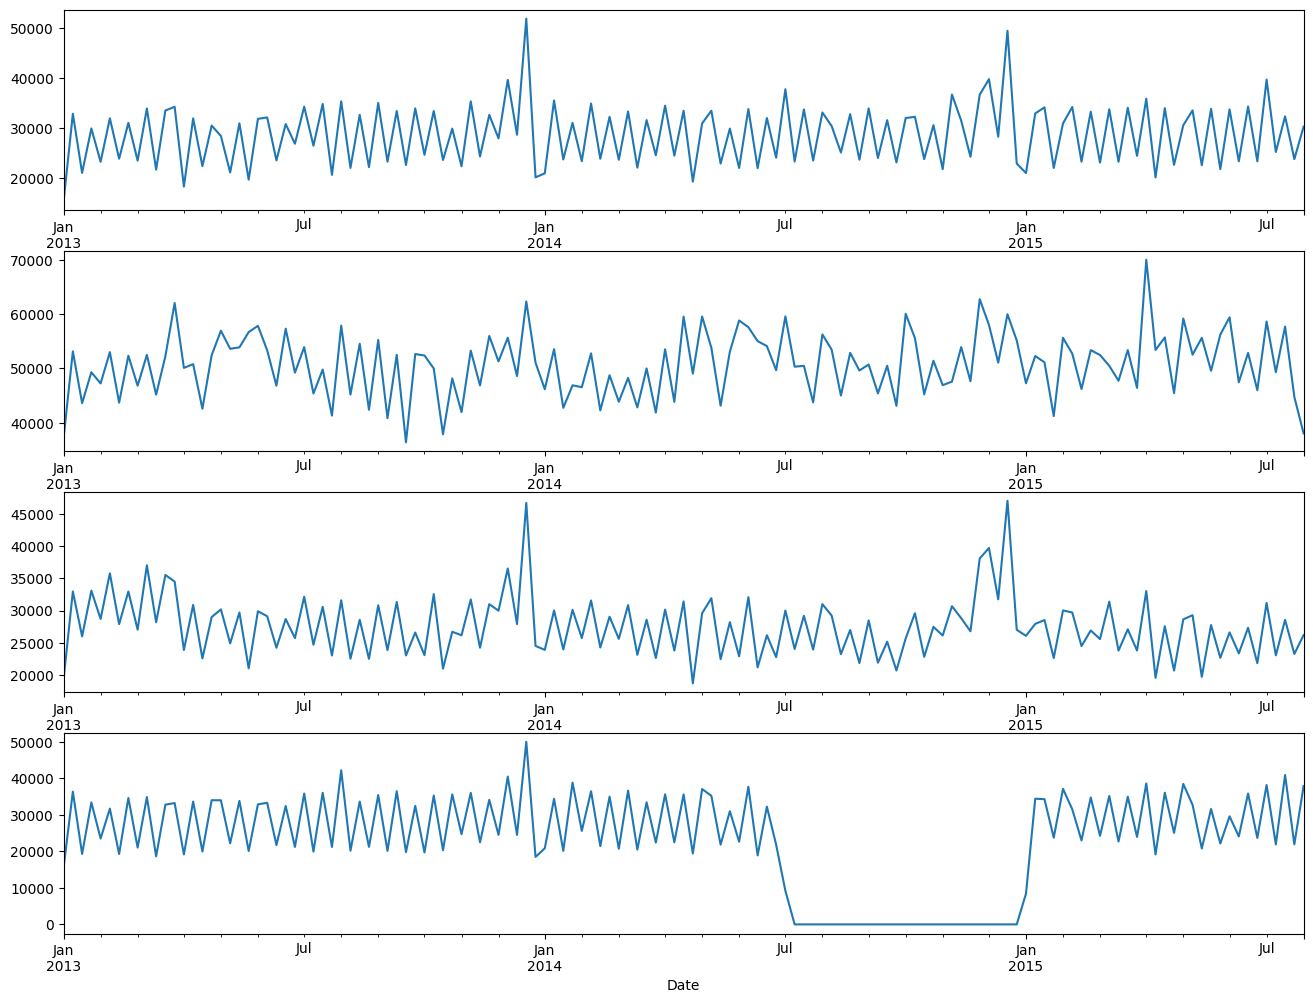

In [ ]:
# Assigning one store from each category
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True)
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']
frame, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (16, 12))

# Visualizing Trend
sales_a.resample('w').sum().plot(ax = ax1)
sales_b.resample('w').sum().plot(ax = ax2)
sales_c.resample('w').sum().plot(ax = ax3)
sales_d.resample('w').sum().plot(ax = ax4)

We can see that sales of store type a and c have highest sales at the end of the year due to christmas and new year season. At the end of the month sales decrease. We can not find similer trend for store b and d. A possible reason is "store is closed".

### Testing Stationarity

In [ ]:
# Function to test the stationarity
def stationarity_test(timeseries):
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()
    plt.subplots(figsize = (16, 6))
    orginal = plt.plot(timeseries.resample('w').mean(), color='blue',linewidth= 3, label='Orginal')
    roll_mean = plt.plot(roll_mean.resample('w').mean(), color='red',linewidth= 3, label='Rolling Mean')
    roll_mean = plt.plot(roll_std.resample('w').mean(), color='green',linewidth= 3, label='Rolling Std')
    plt.legend(loc='best')
    plt.show()

    # Dickey-Fuller test
    print('Result of Dickey-Fuller test:')
    result= adfuller(timeseries, autolag='AIC')
    print('ADF Statestics: %f' %result[0])
    print('P-value: %f' %result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(key, value)

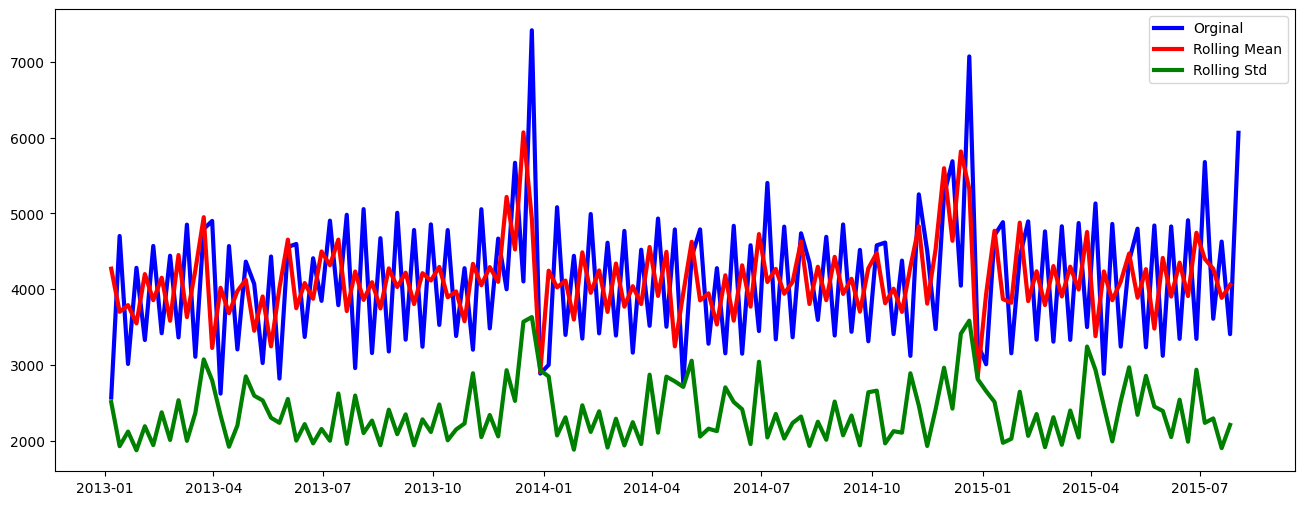

Result of Dickey-Fuller test:
ADF Statestics: -6.218237
P-value: 0.000000
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [ ]:
from statsmodels.tsa.stattools import adfuller
stationarity_test(sales_a)

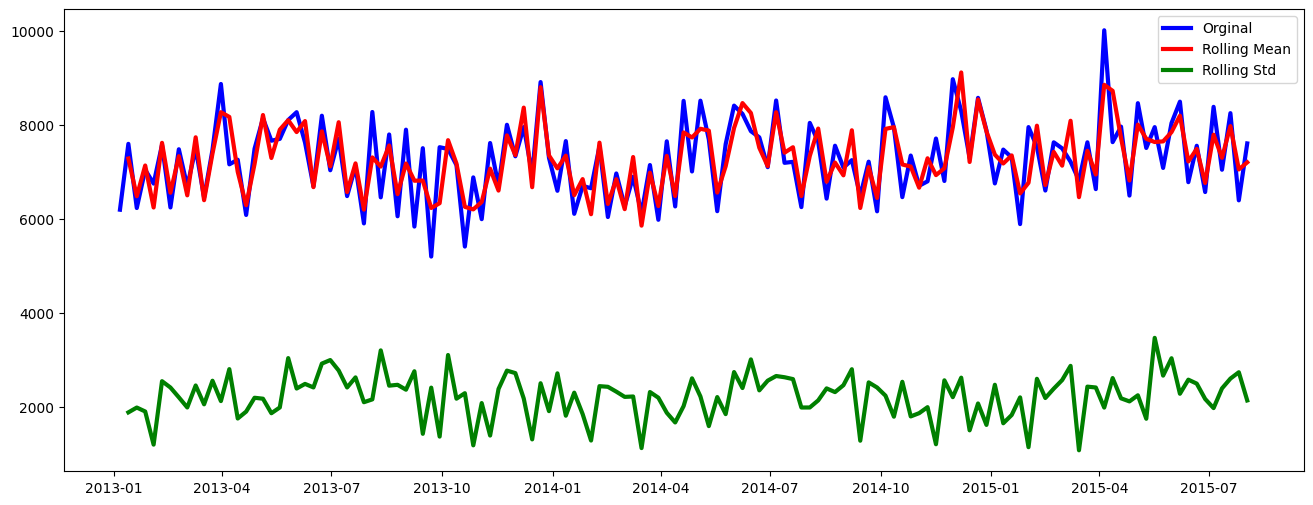

Result of Dickey-Fuller test:
ADF Statestics: -5.660918
P-value: 0.000001
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459


In [ ]:
stationarity_test(sales_b)

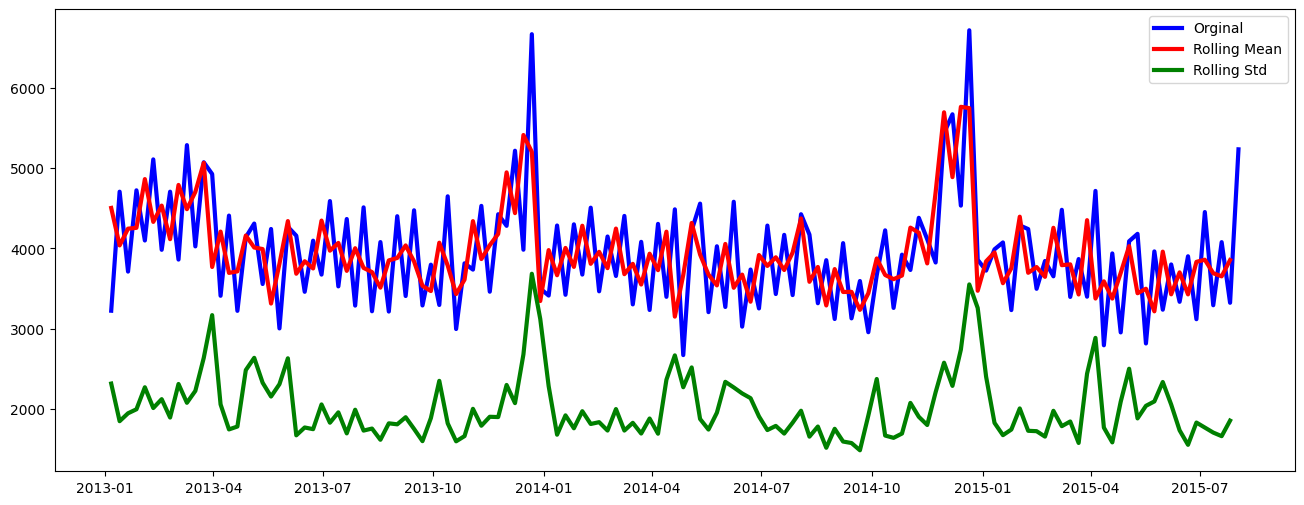

Result of Dickey-Fuller test:
ADF Statestics: -4.374784
P-value: 0.000329
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [ ]:
stationarity_test(sales_c)

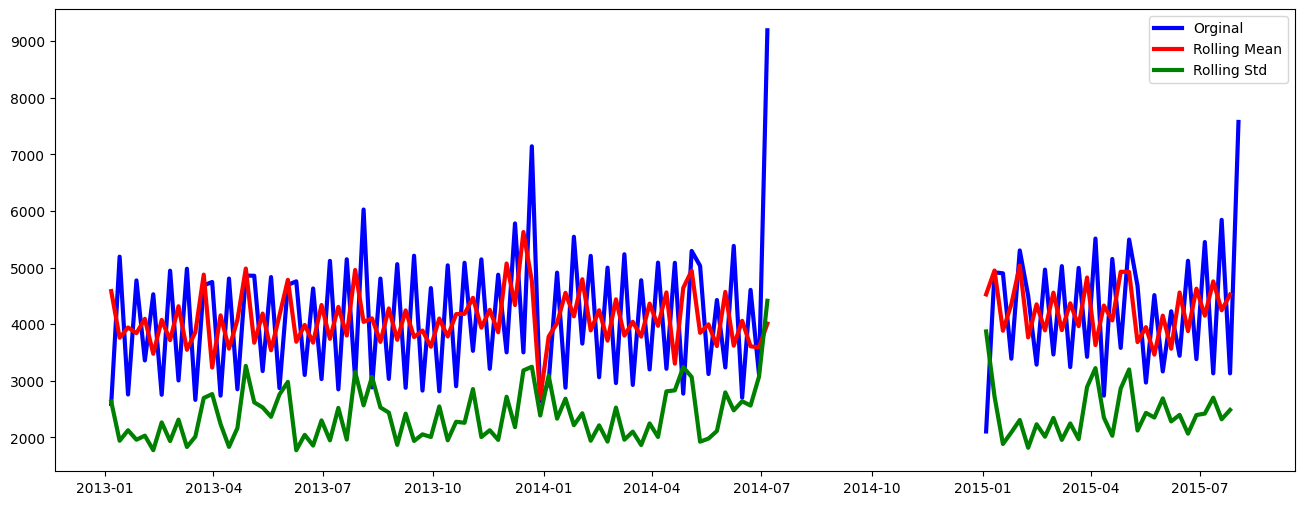

Result of Dickey-Fuller test:
ADF Statestics: -6.237461
P-value: 0.000000
Critical Values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


In [ ]:
stationarity_test(sales_d)

We can observe that mean and variance of the data are not changing over time. So, we do not compute any transformation.

### Trends and Seasonality

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
def plot_timeseries(sales,StoreType):
    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
    fig.set_figheight(6)
    fig.set_figwidth(15)
    decomposition= seasonal_decompose(sales, model = 'additive',period=365)
    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid
    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left');
    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');
    plt.title('Decomposition Plots')

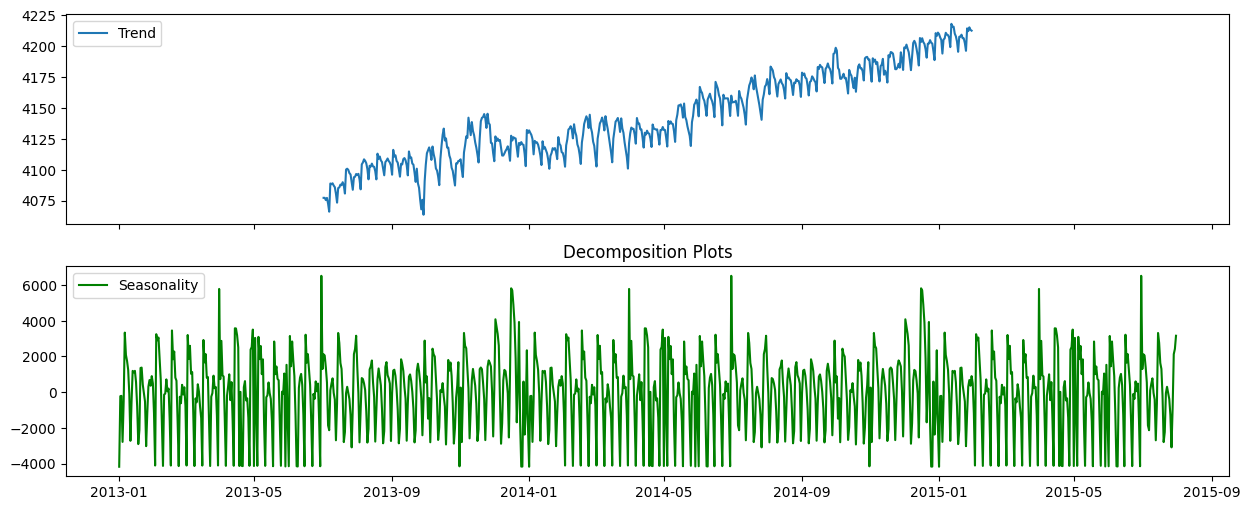

In [ ]:
plot_timeseries(sales_a, 'a')

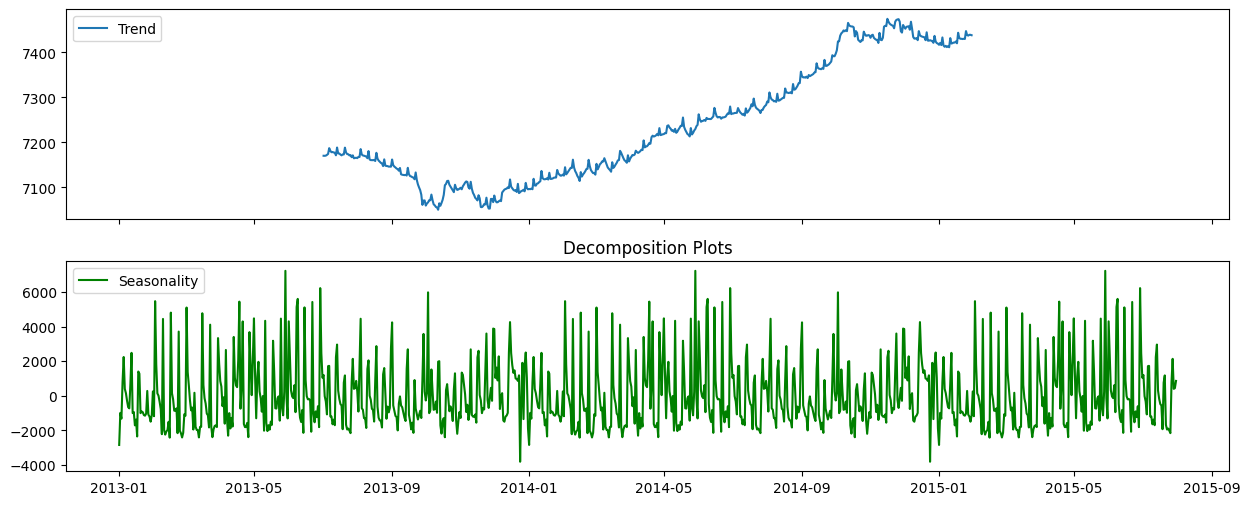

In [ ]:
plot_timeseries(sales_b, 'b')

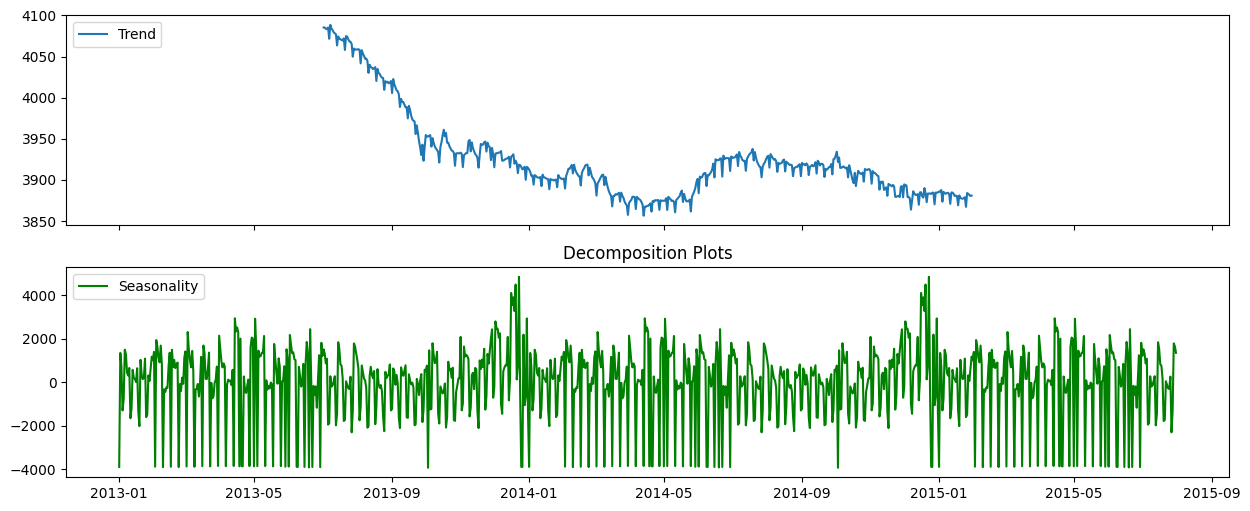

In [ ]:
plot_timeseries(sales_c, 'c')

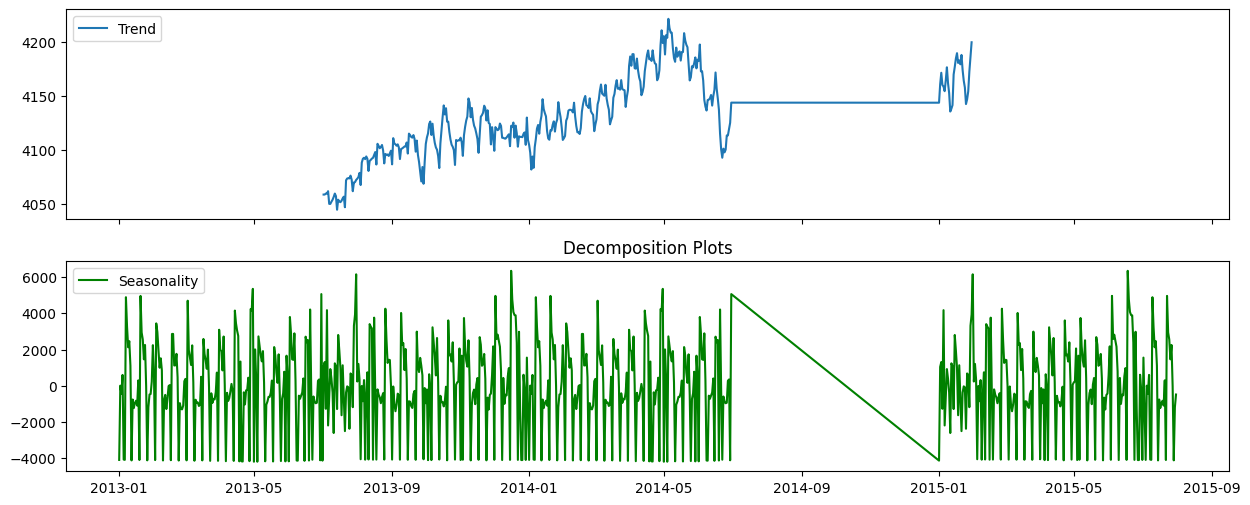

In [ ]:
plot_timeseries(sales_d, 'd')

We can see that there is seasonality and trend present in our data. So, we'll use forecasting models that take both of these factors into consideration. For example, SARIMAX and Prophet.

# **Seasonal Autoregressive Integrated Moving Average (SARIMAX)**

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
def auto_corr(sales):
    lag_acf = acf(sales, nlags=30)
    lag_pacf = pacf(sales,nlags=20,method='ols')
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.title('ACF')
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.title('PACF')


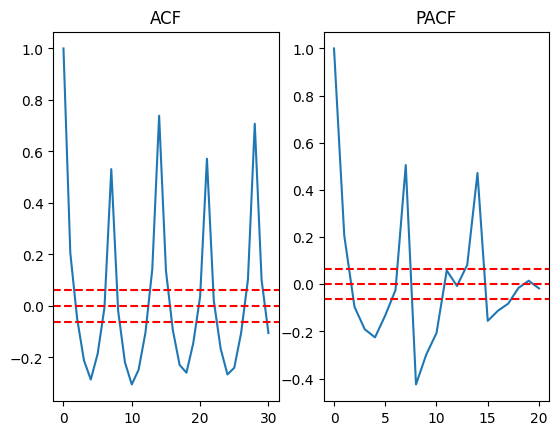

In [ ]:
# ACF and PCF plots for store a
auto_corr(sales_a)

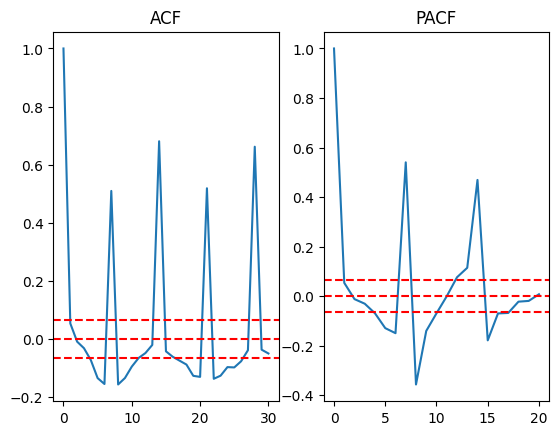

In [ ]:
auto_corr(sales_b)

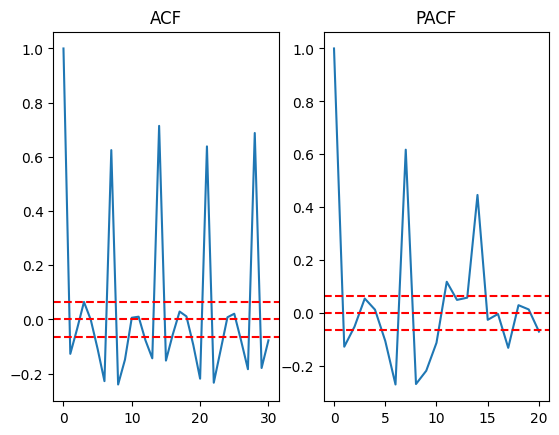

In [ ]:
auto_corr(sales_c)

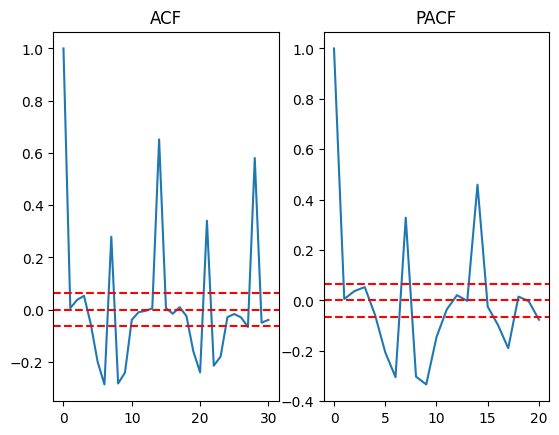

In [ ]:
auto_corr(sales_d)

The above graphs suggest that the p = 2 and q = 2.

In [ ]:
arima_mod_a = sm.tsa.ARIMA(sales_a, order=(2, 1, 2)).fit()
print(arima_mod_a.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  942
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -8612.745
Date:                Tue, 02 Jul 2024   AIC                          17235.491
Time:                        18:02:46   BIC                          17259.725
Sample:                             0   HQIC                         17244.729
                                - 942                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6473      0.063    -10.332      0.000      -0.770      -0.525
ar.L2          0.0997      0.038      2.650      0.008       0.026       0.173
ma.L1         -0.1012      0.067     -1.520      0.1

In [ ]:
arima_mod_b = sm.tsa.ARIMA(sales_b, order=(2, 1, 2)).fit()
print(arima_mod_b.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  942
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -8600.428
Date:                Tue, 02 Jul 2024   AIC                          17210.856
Time:                        18:03:42   BIC                          17235.091
Sample:                    01-01-2013   HQIC                         17220.094
                         - 07-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7998      0.073    -11.022      0.000      -0.942      -0.658
ar.L2         -0.0280      0.044     -0.635      0.525      -0.114       0.058
ma.L1         -0.1135      0.066     -1.719      0.0

In [ ]:
arima_mod_c = sm.tsa.ARIMA(sales_c, order=(2, 1, 2)).fit()
print(arima_mod_c.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  942
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -8460.215
Date:                Tue, 02 Jul 2024   AIC                          16930.431
Time:                        18:03:57   BIC                          16954.665
Sample:                             0   HQIC                         16939.669
                                - 942                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0145      0.043    -23.612      0.000      -1.099      -0.930
ar.L2         -0.2358      0.032     -7.361      0.000      -0.299      -0.173
ma.L1         -0.0684      0.025     -2.737      0.0

In [ ]:
arima_mod_d = sm.tsa.ARIMA(sales_d, order=(2, 1, 2)).fit()
print(arima_mod_d.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  758
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6972.661
Date:                Tue, 02 Jul 2024   AIC                          13955.323
Time:                        18:04:07   BIC                          13978.470
Sample:                             0   HQIC                         13964.238
                                - 758                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8356      0.118     -7.094      0.000      -1.066      -0.605
ar.L2         -0.0474      0.038     -1.265      0.206      -0.121       0.026
ma.L1         -0.1496      0.124     -1.204      0.2

# **Model 2: XGBoost**

In [ ]:
ts_xgboost = joined.copy()
ts_xgboost = ts_xgboost.drop(['Customers', 'SalesPerCustomer', 'PromoInterval'], axis=1)

In [ ]:
ts_xgboost.head()

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
0,1,5,5263,1,1,0,1,2015,7,31,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0
1,1,4,5020,1,1,0,1,2015,7,30,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0
2,1,3,4782,1,1,0,1,2015,7,29,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0
3,1,2,5011,1,1,0,1,2015,7,28,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0
4,1,1,6102,1,1,0,1,2015,7,27,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0


In [ ]:
# Combining similar columns into one column and dropping old columns
ts_xgboost['CompetitionOpen'] = 12 * (ts_xgboost.Year - ts_xgboost.CompetitionOpenSinceYear) + (ts_xgboost.Month - ts_xgboost.CompetitionOpenSinceMonth)
ts_xgboost['PromoOpen'] = 12 * (ts_xgboost.Year - ts_xgboost.Promo2SinceYear) + (ts_xgboost.WeekOfYear - ts_xgboost.Promo2SinceWeek) / 4.0
ts_xgboost = ts_xgboost.drop(["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"], axis = 1)
ts_xgboost = ts_xgboost.drop(["Promo2SinceWeek", "Promo2SinceYear"], axis = 1)

In [ ]:
# Converting categorical cols to numerical cols and removing old cols
mappings = {0:0, "0": 0, "a": 1, "b": 1, "c": 1}
ts_xgboost["StateHoliday_cat"] = ts_xgboost["StateHoliday"].map(mappings)
ts_xgboost["StoreType_cat"] = ts_xgboost["StoreType"].map(mappings)
ts_xgboost["Assortment_cat"] = ts_xgboost["Assortment"].map(mappings)
ts_xgboost = ts_xgboost.drop(["StateHoliday", "StoreType", "Assortment"], axis = 1)

In [ ]:
# Splitting the data
features = ts_xgboost.drop(["Sales"], axis = 1)
target = ts_xgboost["Sales"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(features, target, test_size = 0.20)

In [ ]:
# Baseline XGBoost

# Tuning parameters - using default metrics
params = {'max_depth':6, "booster": "gbtree", 'eta':0.3, 'objective':'reg:linear'}

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Training the model
xgboost = xgb.train(params, dtrain, 100, evals=watchlist,early_stopping_rounds= 100, verbose_eval=True)

# Making predictions
preds = xgboost.predict(dtest)

[0]	train-rmse:3214.69925	eval-rmse:3215.72026
[1]	train-rmse:2846.18631	eval-rmse:2846.99452
[2]	train-rmse:2638.99243	eval-rmse:2639.97588
[3]	train-rmse:2511.86117	eval-rmse:2511.42628
[4]	train-rmse:2436.99458	eval-rmse:2435.38248
[5]	train-rmse:2397.18969	eval-rmse:2396.05930
[6]	train-rmse:2372.62500	eval-rmse:2372.70755
[7]	train-rmse:2352.77507	eval-rmse:2352.75024
[8]	train-rmse:2294.51754	eval-rmse:2293.53507
[9]	train-rmse:2261.25440	eval-rmse:2261.90091
[10]	train-rmse:2247.34560	eval-rmse:2248.33966
[11]	train-rmse:2231.15724	eval-rmse:2232.03280
[12]	train-rmse:2215.67518	eval-rmse:2216.50630
[13]	train-rmse:2159.15910	eval-rmse:2159.16154
[14]	train-rmse:2129.95085	eval-rmse:2131.17850
[15]	train-rmse:2120.92983	eval-rmse:2122.44878
[16]	train-rmse:2114.31697	eval-rmse:2116.27039
[17]	train-rmse:2064.54317	eval-rmse:2066.06514
[18]	train-rmse:2050.83974	eval-rmse:2052.22327
[19]	train-rmse:2045.22903	eval-rmse:2046.71132
[20]	train-rmse:2036.48268	eval-rmse:2037.86385
[2

In [ ]:
# RMSE of model
rms_xgboost = sqrt(mean_squared_error(y_test, preds))
print("Root Mean Squared Error for XGBoost:", rms_xgboost)

Root Mean Squared Error for XGBoost: 1216.0883425414902


In [ ]:
# Hypertuning XGBoost
# Tuning parameters
params_2 = {'max_depth':10, 'eta':0.1,  'gamma': 2}

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Training the model
xgboost_2 = xgb.train(params_2, dtrain, 100, evals=watchlist,early_stopping_rounds= 100, verbose_eval=True)

# Making predictions
preds_2 = xgboost_2.predict(dtest)

[0]	train-rmse:3603.70579	eval-rmse:3607.47803
[1]	train-rmse:3387.62180	eval-rmse:3391.27176
[2]	train-rmse:3202.08070	eval-rmse:3205.65139
[3]	train-rmse:3039.13873	eval-rmse:3042.58595
[4]	train-rmse:2897.19199	eval-rmse:2901.20140
[5]	train-rmse:2777.17687	eval-rmse:2781.14666
[6]	train-rmse:2673.58055	eval-rmse:2677.60576
[7]	train-rmse:2580.76333	eval-rmse:2584.79428
[8]	train-rmse:2507.25075	eval-rmse:2511.56670
[9]	train-rmse:2439.50185	eval-rmse:2444.82025
[10]	train-rmse:2377.54388	eval-rmse:2382.95932
[11]	train-rmse:2333.13736	eval-rmse:2339.14622
[12]	train-rmse:2286.52837	eval-rmse:2291.83144
[13]	train-rmse:2255.15210	eval-rmse:2261.28125
[14]	train-rmse:2225.98569	eval-rmse:2232.83686
[15]	train-rmse:2203.19595	eval-rmse:2210.70248
[16]	train-rmse:2157.11086	eval-rmse:2164.97246
[17]	train-rmse:2130.74495	eval-rmse:2139.56923
[18]	train-rmse:2111.45963	eval-rmse:2121.22848
[19]	train-rmse:2087.22902	eval-rmse:2097.74727
[20]	train-rmse:2062.48444	eval-rmse:2073.56857
[2

In [ ]:
# RMSE of model
rms_xgboost_2 = sqrt(mean_squared_error(y_test, preds_2))
print("Root Mean Squared Error for XGBoost:", rms_xgboost_2)

Root Mean Squared Error for XGBoost: 1106.4122113133926


#**Final XGBoost Model**
After hypertuning, we were able to reduce RMSE from 1216.08 to 1106.41 which is better.